In [ ]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# PARA LANZAR EN EL HW DE IBM
# SE REQUIERE LA ÚLTIMA VERSIÓN
########################
# Instalar versión 1.2.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==1.2.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

In [ ]:
import qiskit
from qiskit_aer import AerSimulator
print('Qiskit version', qiskit.__version__)
import numpy
import scipy
print("Numpy version", numpy.__version__)
print("Scipy version", scipy.__version__)

In [ ]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [ ]:
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex  

<a id='sec_Notebooks_Circ_1_qubit_2'></a>
## Envío de trabajos a un ordenador real de IBM   

Para enviar trabajos a los ordenadores cuánticos de IBM, **en primer lugar necesitamos es una cuenta en [IBMid](https://quantum-computing.ibm.com/).**

Una vez creada la cuenta, hay que tomar el **token** que aparece en la página principal. Este lo pegamos en la línea comentada más abajo, cuando el cliente realiza la conexión.

Vamos a usar ```qiskit_ibm_runtime``` para mandar trabajos y vamos a usar la primitive sampler
- Mas información sobre como guardar la cuenta: https://docs.quantum.ibm.com/guides/setup-channel
- Más información sobre las primitives: https://docs.quantum.ibm.com/guides/get-started-with-primitives
- Más información sobre lanzar sobre el HW real: https://docs.quantum.ibm.com/guides/hello-world#step-4-analyze-the-results

### Creamos un circuito para probar

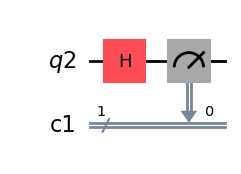

In [7]:
# Creamos el circuito pasandole los registros
qr = QuantumRegister(1)
cr = ClassicalRegistcualeser(1)
circuit_H = QuantumCircuit(qr, cr)

# Añadimos la puerta X al primer (y único) qúbit
circuit_H.h(0)

# Añadimos el medidor
circuit_H.measure(qr, cr)

# Podemos dibujarlo como figura de matplolib
display(circuit_H.draw(output='mpl', style="iqp"))

### Inicializamos la cuenta

Dado que Qiskit Runtime `Sampler` es un servicio gestionado, primero debe inicializar su cuenta. A continuación, puede seleccionar el simulador o el sistema real que desea utilizar para calcular el valor esperado

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account and set it as your default account.
#MY_API_TOKEN="..."
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token='PEGA AQUÍ TU TOKEN DE USUARIO',
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=5)

Veamos el backend (ordenador) escogido:

In [ ]:
print(backend)

### Preparamos el circuito

Vamos a mandar a ejecutar en hardware real el circuito de la puerta H.

Para ello, primero tenemos que generarl el ISA circuit

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit_H = pm.run(circuit_H)

### Inicializamos el Qiskit Runtime Sampler

Al inicializar el `Sampler`, utilice el parámetro `mode` para especificar el modo en el que desea que se ejecute. 

In [ ]:
#from qiskit_ibm_runtime import Sampler
#sampler = Sampler(backend=backend)

#Para versiones modernas de Qiskit
from qiskit_ibm_runtime import SamplerV2 as Sampler  
sampler = Sampler(mode=backend)

### Invocamos el sampler y obtenemos los resultados

In [ ]:
job = sampler.run([isa_circuit_H])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

Podemos monitorizar desde el notebook en que estado está nuestro trabajo. 

Otra obción es hacerlo desde la web de los servicios cuánticos de IBM: **[https://quantum-computing.ibm.com/jobs](https://quantum-computing.ibm.com/jobs)**

La celda siguiente podemos correrla tantas veces como queramos para ver como está nuestro trabajo.

In [ ]:
job.status()

In [ ]:
import time
time.sleep(30)

In [ ]:
job.status()

In [ ]:
print(job.status())

También podemos usar el job_monitor, que se actualiza solo sin tener que ejecutar varias veces la celda.

In [ ]:
#job_monitor(job, interval = 10, line_discipline = '\n') 

In [ ]:
result_IBM = job.result()
print(f">>> {result_IBM}\n")
try:
    print(f"  > Quasi-probability distribution: {result_IBM.quasi_dists[0]}\n")
    print(f"  > Metadata: {result_IBM.metadata[0]}\n")
except:
    pass

<a id='sec_Notebooks_Circ_1_qubit_2.1'></a>
### Recuperar resultados de trabajos anteriores con el job id

Es importante guardar el Job Id, pues con el podemos recuperar los resultados de un trabajo anterior. Por ejemplo, lo que podemos hacer es ejecutar un circuito y si vemos usando `job.status()` que tarda mucho en entrar en ejecución, podemos anotarnos el id y otro ver los resultado, sin tener que dejar el Notebook abierto.

In [ ]:
# Utilizar el job anterior o poner uno existente
# Ver: https://quantum.ibm.com/workloads para la lista de jobs

#job_id="cvrkpwk55th0008rv9q0"
job_id = job.job_id()
print(f"job id = {job_id}")

In [ ]:
# Podemos listar todos los jobs
jobs = service.jobs()
display(jobs)
print("---")

# Coger uno en particular
job = service.job(job_id)
display(job)
print("---")

# Métricas de la ejecución
jmet = job.metrics()
display(jmet)
print("---")

# Resultado de la ejecución (de aquí obtenemos el histograma)
job_result = job.result()
display(job_result)
print("---")

In [ ]:
# Pinchando en un job particular en https://quantum.ibm.com/workloads
# se muestra un código para obtener los resultados del job

# To get counts for a particular pub result, use 
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

pub_result = job_result[0].data.c0.get_counts()
display(pub_result)

In [ ]:
display(plot_histogram(pub_result, figsize=(2,2)))


### Más sobre el HW cuántico IBM

In [ ]:
# Listar todos los backend públicos disponibles
be = []
backends = service.backends()
for backend in backends:
    print(backend.name)
    be.append(backend)

In [ ]:
# Obtener detalles sobre un 'backend' particular (i.e., 'ibmq_manila')

#backend_name = 'ibmq_kyiv'  # Sustituir por el nombre del backend
#backend = service.backend(backend_name)

backend = be[0] # Vamos a coger uno de ellos, el primero

# Backend status
display(backend.status())
display(backend.status().to_dict())
print("--------\n")


# Backend configuration
display(backend.configuration())
#display(backend.configuration().to_dict())
nqubits = backend.configuration().num_qubits
print("# qubits:{0}".format(nqubits))
print("--------\n")

# Backend properties
display(backend.properties())
# display(backend.properties().to_dict())
# Tiempos de decoherencia qubit 0
print("qubit 0, T1={:.6f}".format(backend.properties().t1(0).real))
print("qubit 0, T2={:.6f}".format(backend.properties().t2(0).real))
print("--------\n")


<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
    
<b> <!-- font size="+1"><span style="color:red">[OPCIONAL, PARA OPTAR A NOTA] </span></font --></b>
- Busca infomación sobre los parámetros de decoherencia T1, y T2:  
  - ¿qué significan?
  - ¿de qué manera empírica se podrían obtener?
  

- Obtén alguna(s) medida(s) de las tasas de error que se proporcionan (por ejemplo de lectura de un qubit, o de alguna puerta). Para ello investiga la lista de propiedades proporcionada por el método <tt>backend.properties()</tt>.

<hr>
</div>